In [34]:
import numpy as np
import matplotlib.pyplot as plt
import time, os, sys, gc

import h5py 

from scipy.integrate import solve_ivp

import class_energy as energy
import class_equations_of_motion as eom 

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

## Functions for plotting, IO and time propagation

First: a function that allows quick plotting of wavefunctions

In [35]:
def plot_rotor_wavefunction(x, chosen_My, chosen_Mx, psi):
    A = 6
    plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
    ##plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    #plt.rc('text.latex', preambler=r'\usepackage{textgreek}')
    font_size = 18 

    fig, axs = plt.subplots(chosen_My,chosen_Mx, subplot_kw=dict(polar=True))
    #plt.suptitle(r'$V_0 =$'+str(V_0), fontsize=font_size)

    for i in range(chosen_My):
         for j in range(chosen_Mx):
            axs[i, j].plot(x, psi[(i+int(chosen_My/2))%chosen_My,(j+int(chosen_My/2))%chosen_My], color='lightcoral')

            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_theta_zero_location('E')

            axs[i, j].grid(linewidth=0.5)
            axs[i, j].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    #axs[0, 0].set_theta_zero_location('E')
    #lines, labels = axs[0, 0].set_thetagrids((0, 45, 90, 135, 180), (r'0', ' ', r'$\pi/2$', ' ', r'$\pi$'))

Second: Functions for handling the input and output of the calculation results

In [36]:
def get_file_name(params):
    ''' 
    ----
    Description: get file name for a run
    ----

    ----
    Inputs:
        params (data dict): defines all the calculation variables in a dictionary
    ----

    ----
    Outputs:
        file_name (string): file name
    ----
    '''
    Mx = params["Mx"]
    My = params["My"] 
    tx = params["tx"]
    ty = params["ty"]
    V_0 = params["V_0"]
    B = params["B"]

    file_name = 'tx_'+str(tx)+'_ty_'+str(ty)+'_V0_'+str(V_0)+'_B_'+str(B)+'_Mx_'+str(Mx)+'_My_'+str(My)+'.hfd5'
    return file_name

def save_calculation_run(psi, E_imag, epsilon_imag, params, folder):
    ''' 
    ----
    Description: stores the wavefunction, energies and epsilon criterion during imag time propagation, hdf file format
    ----

    ----
    Inputs:
        psi (3-dimensional: (My,Mx,n)): wavefunction to store
        E_imag (1-dimensional: (number of runs)): energies during the imag time propagation
        epsilon_imag (1-dimensional: (number of runs)): convergence criterion
        params (data dict): defines all the calculation variables in a dictionary
        folder (string): folder path in form '../../'
    ----

    ----
    Outputs:
        file_name (string): file name
    ----
    '''

    file_name = get_file_name(params)
    with h5py.File(folder+file_name, "a") as f:
        if 'phi' in f:
            phi_data = f['phi']
            phi_data[...] = psi
            phi_data.attrs['Mx'] = params['Mx']
            phi_data.attrs['My'] = params['My']
            phi_data.attrs['n']  = params['n']
            phi_data.attrs['tx'] = params['tx']
            phi_data.attrs['ty'] = params['ty']
            phi_data.attrs['V_0'] = params['V_0']
            phi_data.attrs['B'] = params['B']
            phi_data.attrs['qx'] = params['qx']
            phi_data.attrs['qy'] = params['qy']
            phi_data.attrs['tol'] = params['tol']
            phi_data.attrs['dt'] = params['dt']
            phi_data.attrs['init_choice'] = params['init_choice']
        else:
            phi_data = f.create_dataset('phi', data=psi)
            phi_data.attrs['Mx'] = params['Mx']
            phi_data.attrs['My'] = params['My']
            phi_data.attrs['n']  = params['n']
            phi_data.attrs['tx'] = params['tx']
            phi_data.attrs['ty'] = params['ty']
            phi_data.attrs['V_0'] = params['V_0']
            phi_data.attrs['B'] = params['B']
            phi_data.attrs['qx'] = params['qx']
            phi_data.attrs['qy'] = params['qy']
            phi_data.attrs['tol'] = params['tol']
            phi_data.attrs['dt'] = params['dt']
            phi_data.attrs['init_choice'] = params['init_choice']

        if 'e_imag_time_prop' in f:
            e_evo_data = f['e_imag_time_prop']
            e_evo_data[...] = np.array(E_imag)
        else:
            f.create_dataset('e_imag_time_prop', data=np.array(E_imag))

        if 'epsilon_imag_prop' in f:
            epsilon_data = f['epsilon_imag_prop']
            epsilon_data[...] = epsilon_imag
        else:
            f.create_dataset('epsilon_imag_prop', data=epsilon_imag)

    return

def get_psi(file_path):
    with h5py.File(file_path, 'r') as f:
        phi = f['phi']
        e_evo = f['e_imag_time_prop']
        epsilon_evo = f['epsilon_imag_prop']

        params = {"n": int(phi.attrs['n']),
                "Mx": int(phi.attrs['Mx']),
                "Mx_display": 4,
                "converge_new_lattice": "no",
                "My": int(phi.attrs['My']),
                "M": int(phi.attrs['Mx']*phi.attrs['My']),
                "My_display": 4,
                "B": float(phi.attrs['B']),
                "tx": float(phi.attrs['tx']),
                "ty": float(phi.attrs['ty']),
                "V_0": float(phi.attrs['V_0']),
                "qx": int(phi.attrs['qx']),
                "qy": int(phi.attrs['qy']),
                "init_choice": "ferro_domain_vertical_wall",
                "external_wf_tag": " ",
                "excitation_no": 0,
                "angle_pattern": [0,0,0,0],
                "V_0_pattern": [0,0,0,0],
                "n_states": 0,
                "path_to_input_wavefunction": " ",
                "dt": float(phi.attrs['dt']),
                "tol": float(phi.attrs['tol'])}

        phi = f['phi'][...]

    return phi, params

Third: Function for imaginary time propagation

In [37]:
def solve_imag_time_prop(params):
    Mx = params["Mx"]
    My = params["My"]

    n = params["n"]
    V_0 = params["V_0"]

    '''
    EOM and wavefunction manip objects
    '''
    wfn_manip = h_wavef.wavefunc_operations(params=params)
    wavefunc_object = h_wavef.wavefunctions(params=params)
    eom_object = eom.eom(params=params) 

    eom_object.V_0 = V_0
    wavefunc_object.V_0 = V_0 

    psi_init = wavefunc_object.create_init_wavefunction(params['init_choice']) # update for small polaron things
    psi_init = wfn_manip.reshape_one_dim(psi_init)
    
    '''
    Energy Objects
    '''
    energy_object = energy.energy(params=params)
    overlap_object = energy.coupling_of_states(params=params) # needed for overlap calculations
        
    energy_object.V_0 = V_0
    overlap_object.V_0 = V_0

    ''' 
    Lambda expression of right-hand-side of e.o.m
    '''
    func = eom_object.create_integration_function_imag_time_prop() 

    iter = 0
    epsilon = 1 
    tol = params['tol']
    dt  = params['dt']

    E_converge_list = []
    epsilon_list = []
    
    while epsilon > tol:
        '''
        imag time evolution for dt
        '''
        sol = solve_ivp(func, [0,dt], psi_init, method='RK45', rtol=1e-9, atol=1e-9) # method='RK45','DOP853'

        '''
        normalize
        '''
        psi_iter = sol.y.T[-1]
        psi_iter = wfn_manip.normalize_wf(psi_iter, shape=(int(Mx*My),n))

        '''
        compute and save energy and epsilon criterion
        '''
        E = energy_object.calc_energy(psi_iter)
        E_converge_list.append(E[0].real)

        epsilon = eom_object.epsilon_criterion_single_rotor(psi_iter, psi_init)
        epsilon_list.append(epsilon)
        #print('V_0 =', V_0, ', iter step = ' + str(iter+1)+", E =", E[0].real, ", epsilon =", epsilon, "\n")

        '''
        update psi_init
        '''
        psi_init = wfn_manip.reshape_one_dim(psi_iter)

        iter = iter + 1

    psi_out = wfn_manip.reshape_three_dim(psi_init)

    return psi_out, np.array(E_converge_list), np.array(epsilon_list)

In [38]:
def get_tx_ty(sum, diff):
    '''  
    Return tx and ty tunneling rates
    '''
    tx = 0.5*(sum+diff)
    ty = 0.5*(sum-diff)
    return tx, ty

## Define Calculation Parameters

In [39]:
params = {"n": 256,
"M": 36,
"Mx": 6,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 6,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "ferro_domain_vertical_wall",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [150,150,150,150],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-9}

x = (2*np.pi/params["n"])*np.arange(params["n"])

Mx = params["Mx"]
My = params["My"]

n = params["n"]

tx = params["tx"]
ty = params["ty"]

B = params["B"]
V_0 = params["V_0"]

scale = B 

exc_number = params["excitation_no"]

Scan specifications

In [40]:
sum_tx_ty = 200
diff_tx_ty = np.array([-200,-175,-150,-125,-100,-75,-50,-25,-1,1,25,50,75,100,125,150,175,200])
V_0_arr = np.arange(0,355,5) #np.array([0,25,50,75,100,125,150,175,200,225,250])

print(V_0_arr)
for i in diff_tx_ty:
    print(get_tx_ty(sum_tx_ty,i))

[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350]
(0.0, 200.0)
(12.5, 187.5)
(25.0, 175.0)
(37.5, 162.5)
(50.0, 150.0)
(62.5, 137.5)
(75.0, 125.0)
(87.5, 112.5)
(99.5, 100.5)
(100.5, 99.5)
(112.5, 87.5)
(125.0, 75.0)
(137.5, 62.5)
(150.0, 50.0)
(162.5, 37.5)
(175.0, 25.0)
(187.5, 12.5)
(200.0, 0.0)


## 1. Calculations for the Ferro-Order States

In [8]:
def make_fine_grained_potential(tx,ty,V_0_arr):
    if tx > ty: 
        V_0_fo_fd_trans = np.linspace(ty,ty+20,5)
        V_0_fd_sp_trans = np.linspace(100+tx,120+tx,5)
    elif tx <= ty:
        V_0_fo_fd_trans = np.linspace(tx,tx+20,5)
        V_0_fd_sp_trans = np.linspace(100+ty,120+ty,5)

    V_0_arr_run = np.append(V_0_arr,V_0_fo_fd_trans)
    V_0_arr_run = np.append(V_0_arr_run,V_0_fd_sp_trans)

    V_0_arr_run = np.sort(V_0_arr_run)
    return V_0_arr_run

In [ ]:
params["init_choice"] = "uniform"

for j in range(len(diff_tx_ty)):
    tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty[j])

    params["tx"] = tx
    params["ty"] = ty
    
    V_0_arr_run = V_0_arr # make_fine_grained_potential(float(tx),float(ty),V_0_arr)
    for i in range(len(V_0_arr_run)):
        params["V_0"] = V_0_arr_run[i]
        
        '''  
        Imag Time Prop
        '''
        psi, E_evo, epsilon_evo = solve_imag_time_prop(params)
        print('V_0 = ', V_0_arr_run[i], ', tx-ty =', diff_tx_ty[j], ', E =', E_evo[-1])

        '''  
        Store Results
        '''
        folder = 'results/phase_diagram/fo/'
        save_calculation_run(psi, E_evo, epsilon_evo, params, folder)

V_0 =  0 , tx-ty = -200 , E = -400.0
V_0 =  5 , tx-ty = -200 , E = -405.94926914700227
V_0 =  10 , tx-ty = -200 , E = -416.25419131250356
V_0 =  15 , tx-ty = -200 , E = -427.5965019031605
V_0 =  20 , tx-ty = -200 , E = -439.44443475291206
V_0 =  25 , tx-ty = -200 , E = -451.61543901685155
V_0 =  30 , tx-ty = -200 , E = -464.0192196131155
V_0 =  35 , tx-ty = -200 , E = -476.60266593103034
V_0 =  40 , tx-ty = -200 , E = -489.3311088948096
V_0 =  45 , tx-ty = -200 , E = -502.1805110436399
V_0 =  50 , tx-ty = -200 , E = -515.1332328715727
V_0 =  55 , tx-ty = -200 , E = -528.1759202626585
V_0 =  60 , tx-ty = -200 , E = -541.2982763470905
V_0 =  65 , tx-ty = -200 , E = -554.4920099222803
V_0 =  70 , tx-ty = -200 , E = -567.7503317758614
V_0 =  75 , tx-ty = -200 , E = -581.0677543315776
V_0 =  80 , tx-ty = -200 , E = -594.4396509064271
V_0 =  85 , tx-ty = -200 , E = -607.8620205355539
V_0 =  90 , tx-ty = -200 , E = -621.3316078267891
V_0 =  95 , tx-ty = -200 , E = -634.8454898489902
V_0 =  10

## 2. Calculations for the vertical Ferro-Domain States

V_0 =  0 , tx-ty = -100 , E = -399.9256174326883
V_0 =  0 , tx-ty = -50 , E = -399.94546868876483
V_0 =  0 , tx-ty = -25 , E = -399.9463811587329
V_0 =  0 , tx-ty = -5 , E = -399.94982528456177
V_0 =  0 , tx-ty = 0 , E = -399.9504408604505
V_0 =  0 , tx-ty = 5 , E = -399.95041791950933
V_0 =  0 , tx-ty = 25 , E = -399.95089212481776
V_0 =  0 , tx-ty = 50 , E = -399.95169563032573
V_0 =  0 , tx-ty = 100 , E = -399.9517274598618
V_0 =  25 , tx-ty = -100 , E = -351.4728161864433
V_0 =  25 , tx-ty = -50 , E = -301.66002943077694
V_0 =  25 , tx-ty = -25 , E = -276.7840309289912
V_0 =  25 , tx-ty = -5 , E = -256.90016643981676
V_0 =  25 , tx-ty = 0 , E = -251.93593948216704
V_0 =  25 , tx-ty = 5 , E = -246.97325386967765
V_0 =  25 , tx-ty = 25 , E = -227.1318071293906
V_0 =  25 , tx-ty = 50 , E = -202.39507952585953
V_0 =  25 , tx-ty = 100 , E = -153.2872290992575
V_0 =  50 , tx-ty = -100 , E = -415.5436645309939
V_0 =  50 , tx-ty = -50 , E = -366.08431763976444
V_0 =  50 , tx-ty = -25 , E =

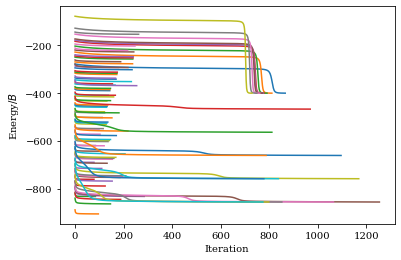

In [10]:
params["init_choice"] = "ferro_domain_vertical_wall"

for j in range(len(diff_tx_ty)):
    tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty[j])

    params["tx"] = tx
    params["ty"] = ty
    
    V_0_arr_run = V_0_arr # make_fine_grained_potential(float(tx),float(ty),V_0_arr)
    for i in range(len(V_0_arr_run)):
        params["V_0"] = V_0_arr_run[i]
        
        '''  
        Imag Time Prop
        '''
        psi, E_evo, epsilon_evo = solve_imag_time_prop(params)
        print('V_0 = ', V_0_arr[i], ', tx-ty =', diff_tx_ty[j], ', E =', E_evo[-1])

        '''  
        Store Results
        '''
        folder = 'results/phase_diagram/fdv/'
        save_calculation_run(psi, E_evo, epsilon_evo, params, folder)

## 3. Calculations for the horizontal Ferro-Domain States

V_0 =  0 , tx-ty = -100 , E = -399.9517274598735
V_0 =  0 , tx-ty = -50 , E = -399.9516956303445
V_0 =  0 , tx-ty = -25 , E = -399.9508921248332
V_0 =  0 , tx-ty = -5 , E = -399.95041791951746
V_0 =  0 , tx-ty = 0 , E = -399.950440860413
V_0 =  0 , tx-ty = 5 , E = -399.94982528456393
V_0 =  0 , tx-ty = 25 , E = -399.9463811587025
V_0 =  0 , tx-ty = 50 , E = -399.9454686888032
V_0 =  0 , tx-ty = 100 , E = -399.9256174327205
V_0 =  25 , tx-ty = -100 , E = -153.2872290992575
V_0 =  25 , tx-ty = -50 , E = -202.3950795258594
V_0 =  25 , tx-ty = -25 , E = -227.131807129391
V_0 =  25 , tx-ty = -5 , E = -246.97325386964118
V_0 =  25 , tx-ty = 0 , E = -251.93593948216713
V_0 =  25 , tx-ty = 5 , E = -256.90016643981664
V_0 =  25 , tx-ty = 25 , E = -276.78403092899146
V_0 =  25 , tx-ty = 50 , E = -301.66002943077723
V_0 =  25 , tx-ty = 100 , E = -351.47281618644405
V_0 =  50 , tx-ty = -100 , E = -220.8845852683683
V_0 =  50 , tx-ty = -50 , E = -268.22357879491216
V_0 =  50 , tx-ty = -25 , E = -29

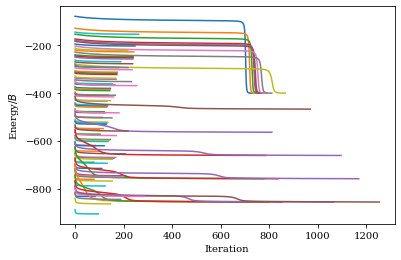

In [11]:
params["init_choice"] = "ferro_domain_horizontal_wall"

for j in range(len(diff_tx_ty)):
    tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty[j])

    params["tx"] = tx
    params["ty"] = ty
    
    V_0_arr_run = V_0_arr # make_fine_grained_potential(float(tx),float(ty),V_0_arr)
    for i in range(len(V_0_arr_run)):
        params["V_0"] = V_0_arr_run[i]
        
        '''  
        Imag Time Prop
        '''
        psi, E_evo, epsilon_evo = solve_imag_time_prop(params)
        print('V_0 = ', V_0_arr[i], ', tx-ty =', diff_tx_ty[j], ', E =', E_evo[-1])

        '''  
        Store Results
        '''
        folder = 'results/phase_diagram/fdh/'
        save_calculation_run(psi, E_evo, epsilon_evo, params, folder)

## 4. Calculations for the Small Polaron States

V_0 =  0 , tx-ty = -100 , E = -400.0
V_0 =  0 , tx-ty = -50 , E = -400.0
V_0 =  0 , tx-ty = -25 , E = -400.0
V_0 =  0 , tx-ty = -5 , E = -400.0
V_0 =  0 , tx-ty = 0 , E = -400.0
V_0 =  0 , tx-ty = 5 , E = -400.0
V_0 =  0 , tx-ty = 25 , E = -400.0
V_0 =  0 , tx-ty = 50 , E = -400.0
V_0 =  0 , tx-ty = 100 , E = -400.0
V_0 =  25 , tx-ty = -100 , E = -404.3884819423053
V_0 =  25 , tx-ty = -50 , E = -403.8755423007911
V_0 =  25 , tx-ty = -25 , E = -403.77520849459563
V_0 =  25 , tx-ty = -5 , E = -403.7405731028491
V_0 =  25 , tx-ty = 0 , E = -403.7394605160024
V_0 =  25 , tx-ty = 5 , E = -403.7405731028496
V_0 =  25 , tx-ty = 25 , E = -403.7752084945936
V_0 =  25 , tx-ty = 50 , E = -403.87554230079013
V_0 =  25 , tx-ty = 100 , E = -404.3884819423045
V_0 =  50 , tx-ty = -100 , E = -180.35198024470034
V_0 =  50 , tx-ty = -50 , E = -180.33866760842224
V_0 =  50 , tx-ty = -25 , E = -180.33643429746854
V_0 =  50 , tx-ty = -5 , E = -180.33623879750894
V_0 =  50 , tx-ty = 0 , E = -180.336230652639

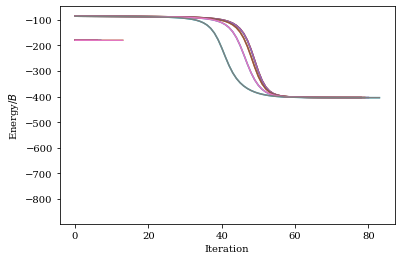

In [12]:
params["init_choice"] = "small_polaron"

for j in range(len(diff_tx_ty)):
    tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty[j])

    params["tx"] = tx
    params["ty"] = ty
    
    V_0_arr_run = V_0_arr # make_fine_grained_potential(float(tx),float(ty),V_0_arr)
    for i in range(len(V_0_arr_run)):
        params["V_0"] = V_0_arr_run[i]
        
        '''  
        Imag Time Prop
        '''
        psi, E_evo, epsilon_evo = solve_imag_time_prop(params)
        print('V_0 = ', V_0_arr[i], ', tx-ty =', diff_tx_ty[j], ', E =', E_evo[-1])

        '''  
        Store Results
        '''
        folder = 'results/phase_diagram/sp/'
        save_calculation_run(psi, E_evo, epsilon_evo, params, folder)

In [41]:
def get_psi_properties(file_path, check_size, check_sym):
    file_list = [f for f in os.listdir(file_path) if check_size in f and check_sym in f]

    V_0_arr = np.zeros(len(file_list), dtype=complex)

    E_arr = np.zeros(len(file_list), dtype=complex)
    B_arr = np.zeros(len(file_list), dtype=complex)
    V_arr = np.zeros(len(file_list), dtype=complex)
    Tx_arr = np.zeros(len(file_list), dtype=complex)
    Ty_arr = np.zeros(len(file_list), dtype=complex)

    i = 0
    for file in file_list:
        psi, params = get_psi(file_path+file)

        energy_object = energy.energy(params=params)

        E = energy_object.calc_energy(psi) # in form [E, E_T, E_B, E_V]
        Tx, Ty = energy_object.deriv_dE_dt(psi)

        E_arr[i] = E[0]
        B_arr[i] = E[2]
        V_arr[i] = E[3]
        Ty_arr[i] = Ty
        Tx_arr[i] = Tx

        V_0_arr[i] = params['V_0']

        i += 1

    index_sort = np.argsort(V_0_arr)

    V_0_arr = V_0_arr[index_sort]

    E_arr = E_arr[index_sort]
    B_arr = B_arr[index_sort]
    V_arr = V_arr[index_sort]
    Tx_arr = Tx_arr[index_sort]
    Ty_arr = Ty_arr[index_sort]

    print(len(E_arr))
    return V_0_arr, E_arr, B_arr, V_arr, Tx_arr, Ty_arr

In [67]:
def get_e_arr(check_size, sum_tx_ty, diff_tx_ty, file_path):
    V_0_order = []
    E_order = []
    B_order = []
    V_order = []
    Tx_order = []
    Ty_order = []
    for j in range(len(diff_tx_ty)):
        tx, ty = get_tx_ty(sum_tx_ty, diff_tx_ty[j])

        check_sym  = 'tx_'+str(tx)+'_ty_'+str(ty)
        V_0_list, E_arr, B_arr, V_arr, Tx_arr, Ty_arr = get_psi_properties(file_path, check_size, check_sym)

        V_0_order.append(V_0_list)
        E_order.append(E_arr)
        B_order.append(B_arr)
        V_order.append(V_arr)
        Tx_order.append(Tx_arr)
        Ty_order.append(Ty_arr)
    
    V_0_order = np.array([x for x in V_0_order])
    E_order = np.array([x for x in E_order])
    B_order = np.array([x for x in B_order])
    V_order = np.array([x for x in V_order])
    Tx_order = np.array([x for x in Tx_order])
    Ty_order = np.array([x for x in Ty_order])

    return V_0_order, E_order, Tx_order, Ty_order

In [95]:
''' 
FO Results
'''
Mx = 6
My = 6
check_size = 'Mx_'+str(Mx)+'_My_'+str(My)
file_path = 'results/phase_diagram/fo/'

print('Reading results from FO calculations - please wait!')
V_0_arr, E_arr_fo, Tx_fo, Ty_fo = get_e_arr(check_size, sum_tx_ty, diff_tx_ty, file_path)

''' 
FDh Results
'''
Mx = 16
My = 4
check_size = 'Mx_'+str(Mx)+'_My_'+str(My)
file_path = 'results/phase_diagram/fdh/'

print('Reading results from FDh calculations - please wait!')
V_0_arr, E_arr_fdh, Tx_fdh, Ty_fdh = get_e_arr(check_size, sum_tx_ty, diff_tx_ty, file_path)

''' 
SP Results
'''
Mx = 8
My = 8
check_size = 'Mx_'+str(Mx)+'_My_'+str(My)
file_path = 'results/phase_diagram/sp/'

print('Reading results from SP calculations - please wait!')
V_0_arr, E_arr_sp, Tx_sp, Ty_sp = get_e_arr(check_size, sum_tx_ty, diff_tx_ty, file_path)

Reading results from FO calculations - please wait!
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
Reading results from FDh calculations - please wait!
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
Reading results from SP calculations - please wait!
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71


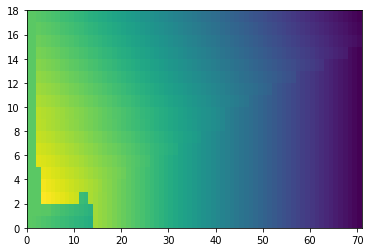

In [104]:
E_arr_fdv = np.flip(E_arr_fdh.copy(), axis=0)
Tx_fdv = np.flip(Ty_fdh.copy(), axis=0)
Ty_fdv = np.flip(Tx_fdh.copy(), axis=0)

plt.pcolormesh(E_arr_fdh.real)

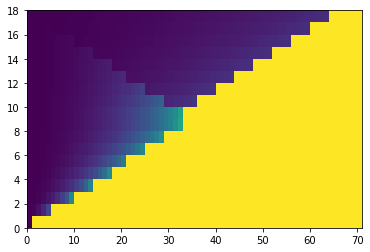

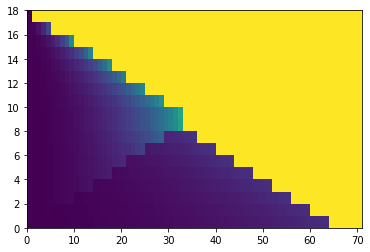

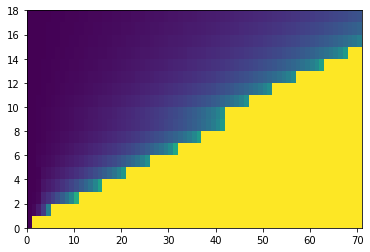

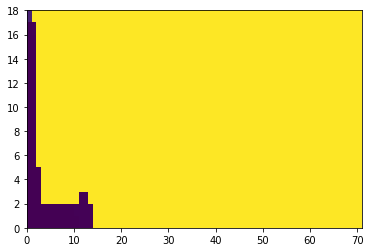

In [81]:
plt.pcolormesh(Tx_fo.real); plt.show()
plt.pcolormesh(Ty_fo.real); plt.show()
plt.pcolormesh(Tx_fdh.real); plt.show()
plt.pcolormesh(Ty_fdh.real); plt.show()

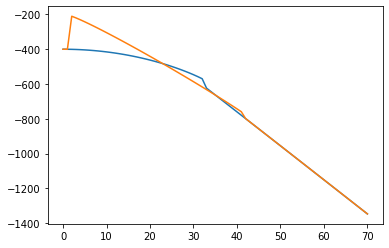

In [33]:
plt.plot(E_fo_arr[8])
plt.plot(E_fdh_arr[8])

In [99]:
print(E_arr_fo[0].shape)
print(E_arr_fo[0,1])
print(len(V_0_arr[0]))
print(len(diff_tx_ty))

(71,)
(-405.94926914700227+4.525921897829133e-18j)
71
18


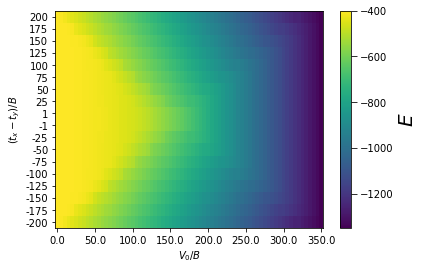

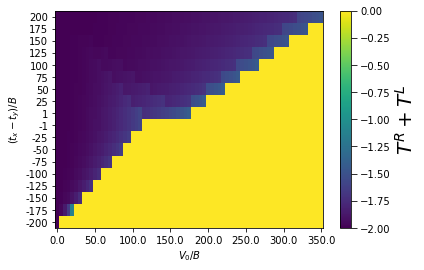

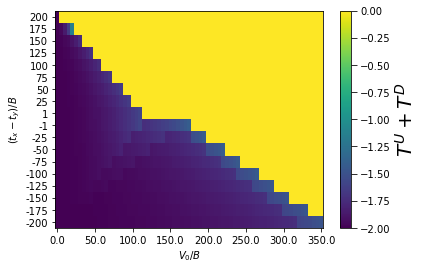

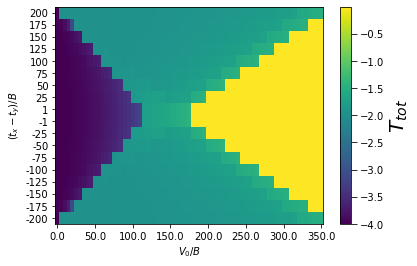

In [149]:
state_no = 0

E_gs = np.zeros(E_fo_arr.shape, dtype=complex)
Tx_order = np.zeros(E_fo_arr.shape, dtype=complex)
Ty_order = np.zeros(E_fo_arr.shape, dtype=complex)

order_p = np.zeros(E_fo_arr.shape, dtype=complex)

for i in range(len(diff_tx_ty)):
    for j in range(len(V_0_arr[0])):
        E_fo  = E_arr_fo[i,j].real
        E_fdv = E_arr_fdv[i,j].real
        E_fdh = E_arr_fdh[i,j].real
        E_sp  = E_arr_sp[i,j].real

        Tx_fo_s  = Tx_fo[i,j]
        Tx_fdv_s = Tx_fdv[i,j]
        Tx_fdh_s = Tx_fdh[i,j]
        Tx_sp_s  = Tx_sp[i,j]

        Ty_fo_s  = Ty_fo[i,j]
        Ty_fdv_s = Ty_fdv[i,j]
        Ty_fdh_s = Ty_fdh[i,j]
        Ty_sp_s  = Ty_sp[i,j]

        E_arr  = np.array([E_fo,E_fdv,E_fdh,E_sp])
        Tx_arr = np.array([Tx_fo_s,Tx_fdv_s,Tx_fdh_s,Tx_sp_s])
        Ty_arr = np.array([Ty_fo_s,Ty_fdv_s,Ty_fdh_s,Ty_sp_s])

        E_index = np.argsort(E_arr)

        E_arr  = E_arr[E_index]
        Tx_arr = Tx_arr[E_index]
        Ty_arr = Ty_arr[E_index]
        
        E_gs[i,j] = E_arr[state_no]
        Tx_order[i,j] = Tx_arr[state_no]
        Ty_order[i,j] = Ty_arr[state_no]
        
        order_p[i,j] = Tx_arr[state_no] + Ty_arr[state_no]
        if E_fdv == np.min(E_arr) and E_fdv < E_fdh:
            order_p[i,j] = order_p[i,j]
        elif E_fdh == np.min(E_arr) and E_fdh < E_fdv:
            order_p[i,j] = order_p[i,j]
        
fig = plt.figure()
pc = plt.pcolormesh(E_gs.real)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(length=6)
cbar.set_label(label=r'$E$', size=20)

plt.xticks(np.arange(len(V_0_arr[0]))[0::10]+0.5, V_0_arr[0][0::10].real)
plt.yticks(np.arange(len(diff_tx_ty))+0.5, diff_tx_ty)
plt.xlabel(r'$V_0/B$')
plt.ylabel(r'$(t_x-t_y)/B$')

plt.savefig('phase_diagram_energies.pdf')
plt.show()

fig = plt.figure()
pc = plt.pcolormesh(Tx_order.real)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(length=6)
cbar.set_label(label=r'$T^R+T^L$', size=20)

plt.xticks(np.arange(len(V_0_arr[0]))[0::10]+0.5, V_0_arr[0][0::10].real)
plt.yticks(np.arange(len(diff_tx_ty))+0.5, diff_tx_ty)
plt.xlabel(r'$V_0/B$')
plt.ylabel(r'$(t_x-t_y)/B$')

plt.show()

fig = plt.figure()
pc = plt.pcolormesh(Ty_order.real)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(length=6)
cbar.set_label(label=r'$T^U+T^D$', size=20)

plt.xticks(np.arange(len(V_0_arr[0]))[0::10]+0.5, V_0_arr[0][0::10].real)
plt.yticks(np.arange(len(diff_tx_ty))+0.5, diff_tx_ty)
plt.xlabel(r'$V_0/B$')
plt.ylabel(r'$(t_x-t_y)/B$')

plt.show()

fig = plt.figure()
pc = plt.pcolormesh(order_p.real)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(length=6)
cbar.set_label(label=r'$T_{tot}$', size=20)

plt.xticks(np.arange(len(V_0_arr[0]))[0::10]+0.5, V_0_arr[0][0::10].real)
plt.yticks(np.arange(len(diff_tx_ty))+0.5, diff_tx_ty)
plt.xlabel(r'$V_0/B$')
plt.ylabel(r'$(t_x-t_y)/B$')

plt.savefig('phase_diagram_order_param1.pdf')
plt.show()

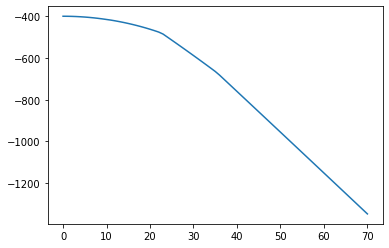

In [102]:
plt.plot(E_gs[8])

-175


NameError: name 'E_sp_arr' is not defined

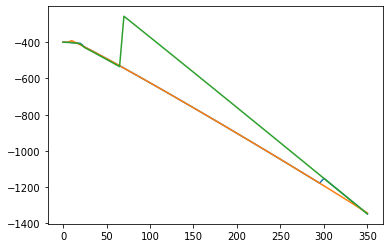

In [148]:
symmetry_index = 1

print(diff_tx_ty[symmetry_index])

%matplotlib inline
plt.plot(V_0_arr[0], E_fo_arr[symmetry_index])
plt.plot(V_0_arr[0], E_fdv_arr[symmetry_index])
plt.plot(V_0_arr[0], E_fdh_arr[symmetry_index])
plt.plot(V_0_arr[0], E_sp_arr[symmetry_index])

#plt.plot(V_0_arr, E_gs.T[0])